In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.patches as patches

from config import Config
import utils
import model as modellib
import visualize
from model import log

os.environ["CUDA_VISIBLE_DEVICES"]="1"

%matplotlib inline                                                                                                                                


# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_ocr_0002.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "data/image")

/home/nghia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import ocr
    
config = ocr.OcrConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        180
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  512
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           ocr
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING       

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
# Training dataset
dataset_train = ocr.OcrDataset()
dataset_train.load_ocr(np.load('ocr-train-cv.npy'), './data/dataset_resized_ver2', './data/dataset_json_ver2', 1024, 1024)
dataset_train.prepare()

# Validation dataset
dataset_val = ocr.OcrDataset()
dataset_val.load_ocr(np.load('ocr-val.npy'), './data/dataset_resized_ver2', './data/dataset_json_ver2', 1024, 1024)
# dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

(55,)
(1024, 1024, 55)


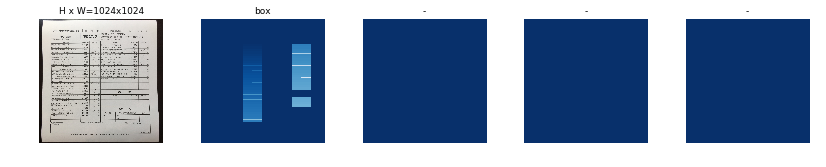

In [5]:
# Load and display random samples
plt.figure(figsize=(10, 10))
image_ids = np.random.choice(dataset_train.image_ids, 1)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(class_ids.shape)
    print(mask.shape)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [6]:
# class InferenceConfig(ocr.Config()):
#     GPU_COUNT = 1
#     IMAGES_PER_GPU = 1

# inference_config = InferenceConfig()
config.GPU_COUNT =1
config.IMAGES_PER_GPU =1
config.BATCH_SIZE = 1
    
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_ocr_0002.h5")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/nghia/work/Mask_RCNN/logs/ocr20180406T1009/mask_rcnn_ocr_0010.h5


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    2.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -115.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000
(53, 4)
(1024, 1024, 53)
(53,)


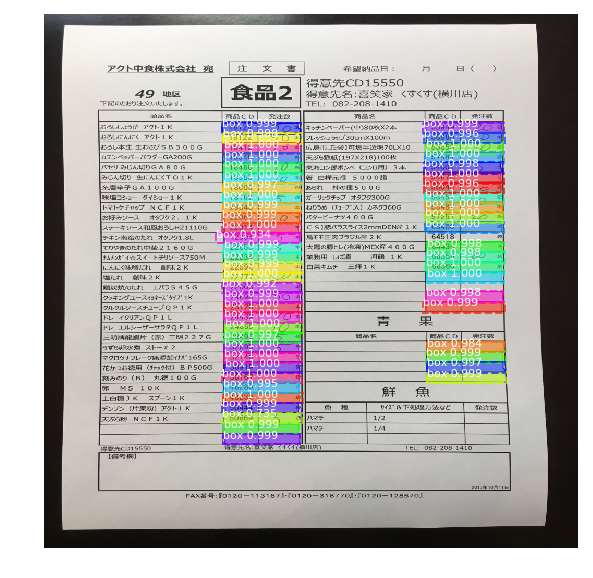

In [7]:
# Test on a random image
image_id = 3
# image_id = random.choice(dataset_val.image_ids)
# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, 
                           image_id, use_mini_mask = False)

results = model.detect([original_image], verbose=1)

r = results[0]
print(r['rois'].shape)
print(r['masks'].shape)
print(r['scores'].shape)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(10, 10))

In [8]:
from skimage.measure import find_contours
from matplotlib.patches import Polygon

print(r['masks'].shape)
print(r['masks'][:,:,0].shape)

masks = r['masks']
classes = r['class_ids']
print(classes.shape)

i = 1
mask = masks[:, :, i]
# masked_image = apply_mask(masked_image, mask, color)

# Mask Polygon
# Pad to ensure proper polygons for masks that touch image edges.
padded_mask = np.zeros(
    (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
padded_mask[1:-1, 1:-1] = mask
contours = find_contours(padded_mask, 0.5)

(1024, 1024, 53)
(1024, 1024)
(53,)


In [9]:
# import the necessary packages
import numpy as np
import cv2

def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
#     print("four_point_transform rect", rect)

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

In [10]:
from skimage.feature import corner_harris, corner_peaks
import matplotlib.patches

def predict_mask(original_image, mask, box):
    y1, x1, y2, x2 = box

    # Mask Polygon
    # Pad to ensure proper polygons for masks that touch image edges.
#     print("box", box)
#     print("original_image", original_image.shape)
#     print("mask", mask.shape)
    padded_mask = np.zeros(
        (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
#     print("padded_mask", padded_mask.shape)
#     plt.imshow(padded_mask)
#     plt.show()
    verts1 = corner_peaks(corner_harris(padded_mask), min_distance=1)
#     print("corner_harris", verts1.shape)
#     print(verts1)
#     verts1 = np.append(verts1, [[y1-5, x1-5], [y2+5, x2+5]], axis=0)
#     print(verts1)
#     verts1.stack((np.array(y1, x1), np.array(y2, x2)))
    verts1 = np.fliplr(verts1) - 1
#     print(verts1.shape)
    crop_img = original_image.copy()
    
#     print(boxes[i])
#     crop_img
    crop_img = crop_img[y1-5:y2+5,x1-1:x2+1,:]
#     print("crop_img", crop_img.shape)
#     plt.imshow(crop_img[y1:y2,x1:x2,:])
#     plt.show()
#     plt.figure(figsize=(12, 12))
    image = original_image.copy()
    pts = np.array(verts1, dtype = "float32")
    rect = order_points(pts)
#     print("pts", pts)
#     print("rect", rect)
    (tl, tr, br, bl) = rect
    
    rect[0] = [tl[0]-1, tl[1]-8]
    rect[1] = [tr[0]+1, tr[1]-8]
    rect[2] = [br[0]+1, br[1]+8]
    rect[3] = [bl[0]-1, bl[1]+8]
#     print("rect0", rect[0])
#     print("rect1", rect[1])
#     pts.concatenate([[x1, y1]], [[x2, y2]])

    # apply the four point tranform to obtain a "birds eye view" of
    # the image
    warped = four_point_transform(image, rect)
#     print("warped", warped.shape)
    return crop_img, warped
#     text = pytesseract.image_to_string(warped, config='')

In [61]:
def extract_pred(image_id, original_image, masks, boxes, classes, class_pred=2, save_dir=''):
    crops = []
    wraps = []
    for i in range(masks.shape[2]):
#         print(i)
        mask = masks[:, :, i]
        box = boxes[i]
        class_id = classes[i]
        if class_id == class_pred:
            crop_img, warped = predict_mask(original_image, mask, box)
            crops.append(crop_img)
            wraps.append(warped)
            if False:
                p_crop = os.path.join(save_dir, "%03d_%03d_crop.jpg" % (image_id, i))
                p_wrap = os.path.join(save_dir, "%03d_%03d_wrap.jpg" % (image_id, i))
#                 print(p_crop)
#                 print(p_wrap)
                cv2.imwrite(p_crop, crop_img)
                cv2.imwrite(p_wrap, warped)
            if False:
                print("crop")
                plt.figure(figsize=(12, 12))
                plt.imshow(crop_img)
                plt.show()
                print("wraped")
                plt.figure(figsize=(12, 12))
                plt.imshow(warped)
                plt.show()
    
    return crops, wraps

In [12]:
def predict_and_extract(image_id, dataset_val, save_dir=""):
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, config, 
                               image_id, use_mini_mask = False)

    results = model.detect([original_image], verbose=1)

    r = results[0]
    print(r['masks'].shape)
    print(r['rois'].shape)
    print(r['class_ids'].shape)
    extract_pred(image_id, original_image, r['masks'], r['rois'],  r['class_ids'], class_pred=1, save_dir=save_dir)
    # visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
    #                             dataset_val.class_names, r['scores'], figsize=(10, 10))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    2.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -117.70000  max:  150.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000
(1024, 1024, 56)
(56, 4)
(56,)
crop


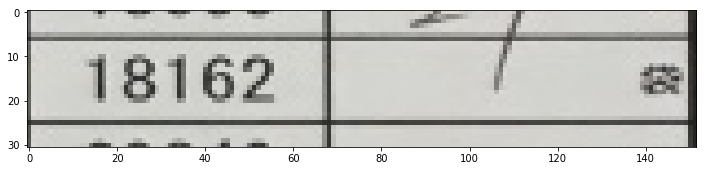

wraped


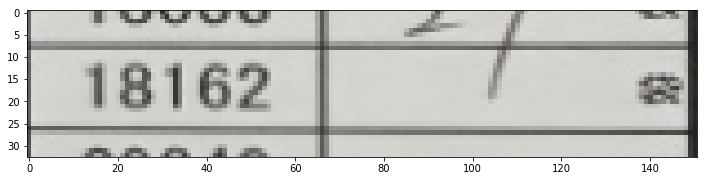

crop


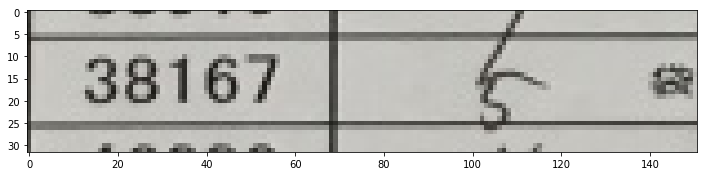

wraped


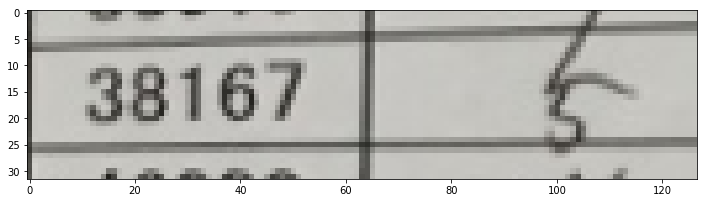

crop


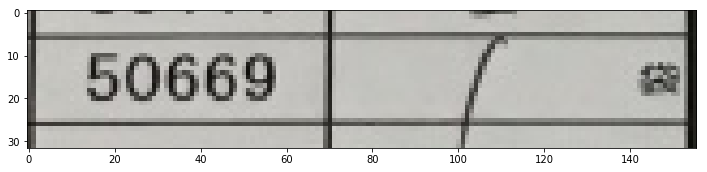

wraped


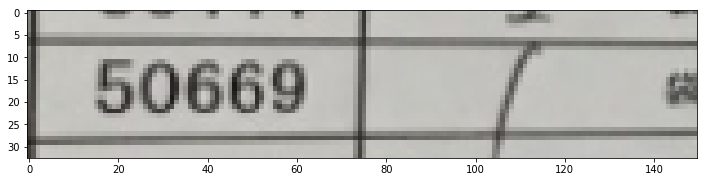

crop


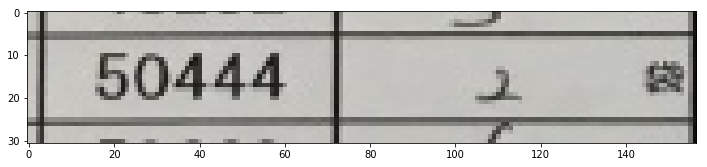

wraped


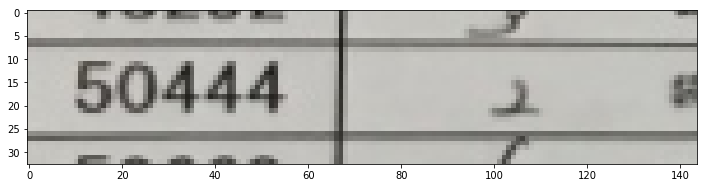

crop


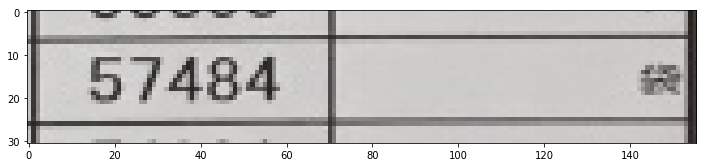

wraped


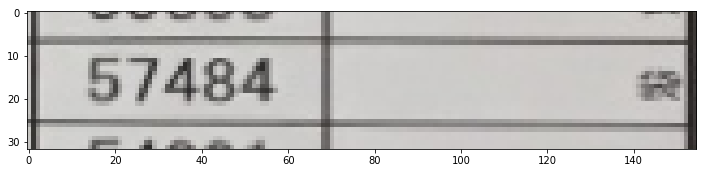

crop


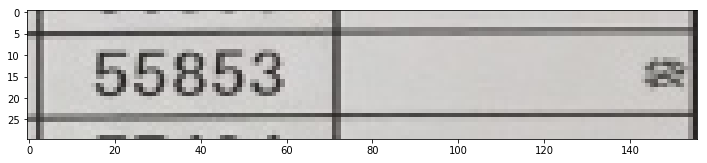

wraped


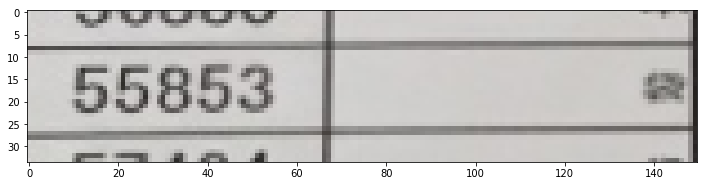

crop


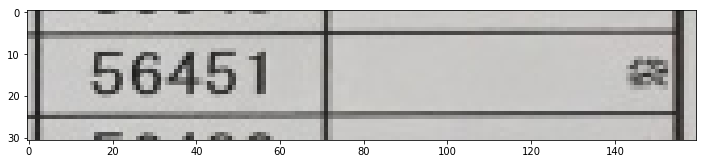

wraped


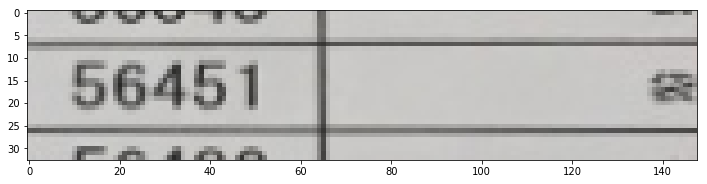

crop


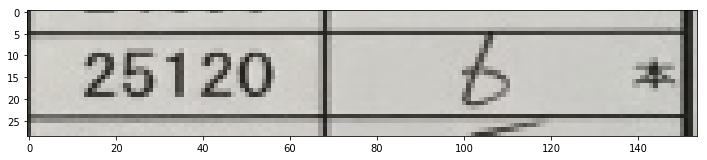

wraped


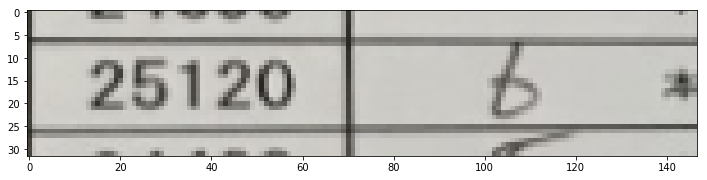

crop


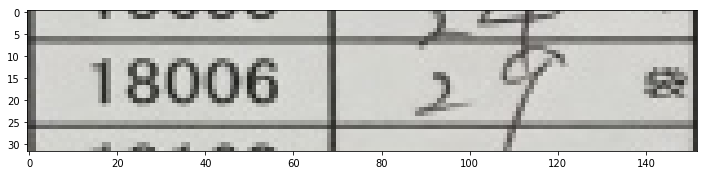

wraped


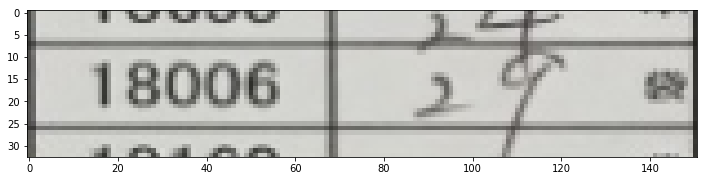

crop


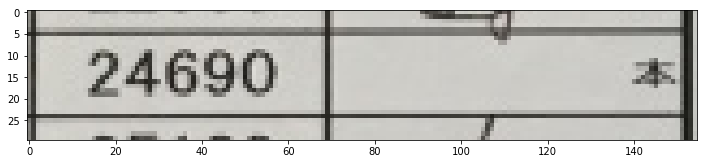

wraped


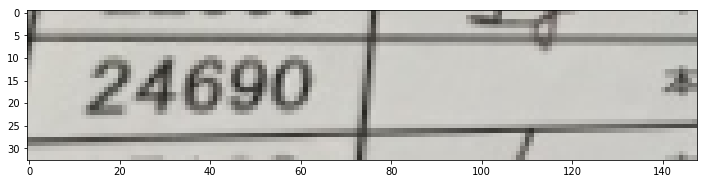

crop


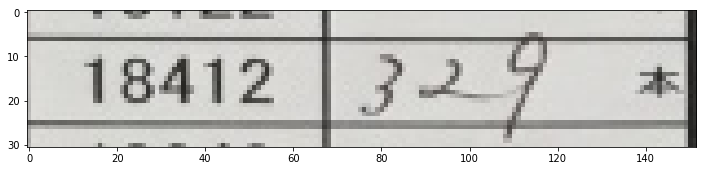

wraped


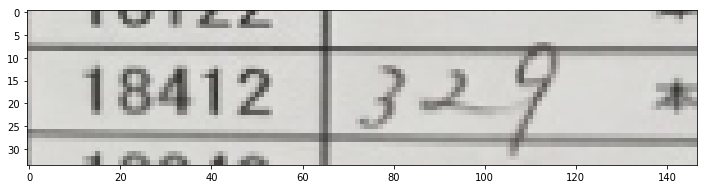

crop


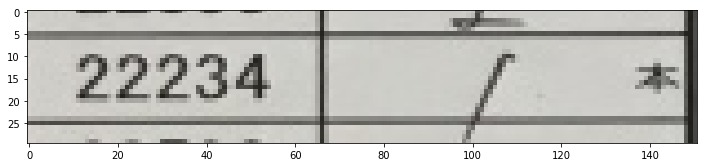

wraped


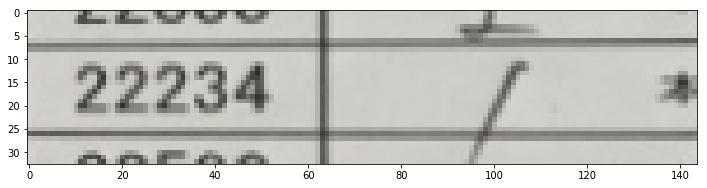

crop


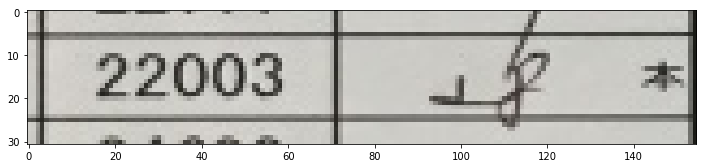

wraped


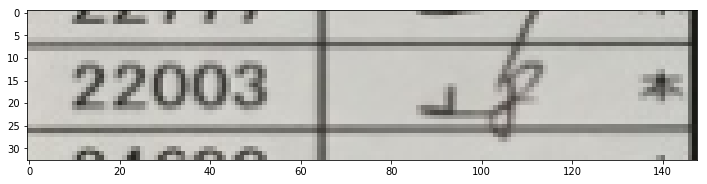

crop


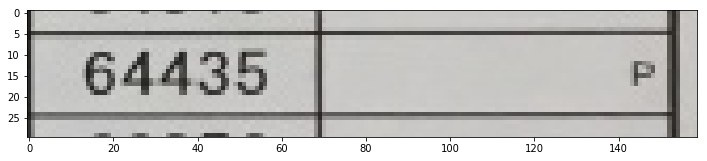

wraped


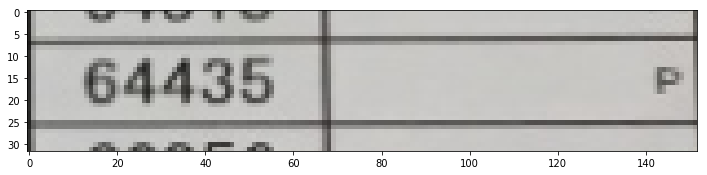

crop


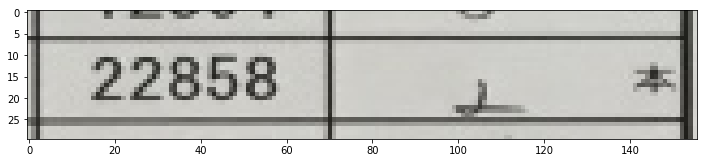

wraped


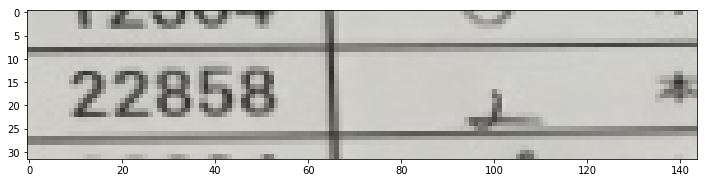

crop


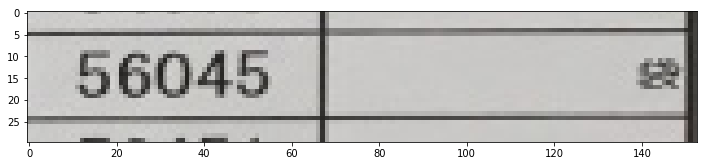

wraped


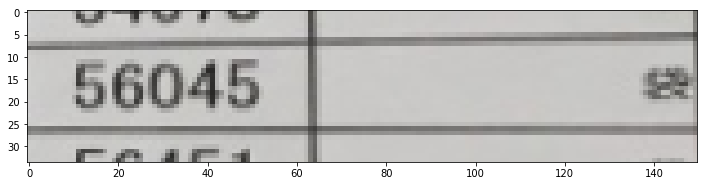

crop


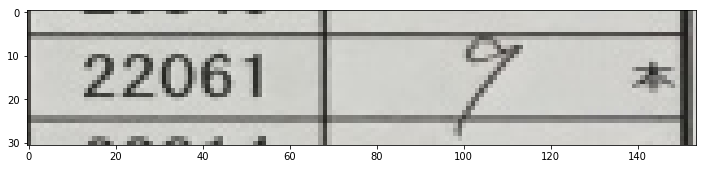

wraped


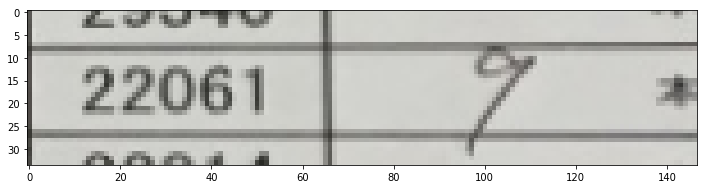

crop


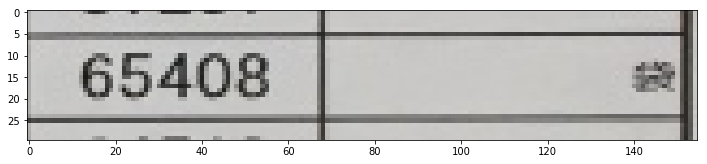

wraped


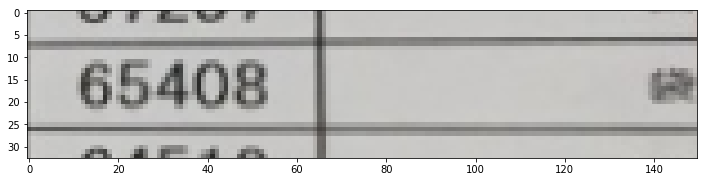

crop


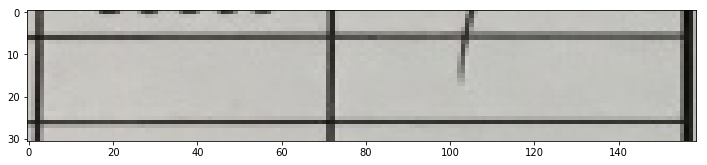

wraped


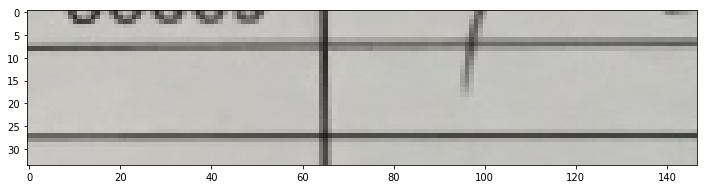

crop


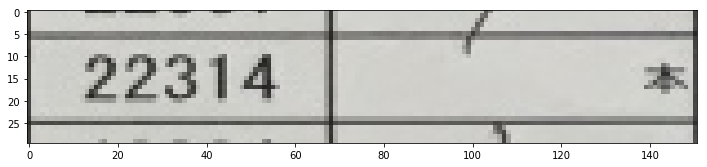

wraped


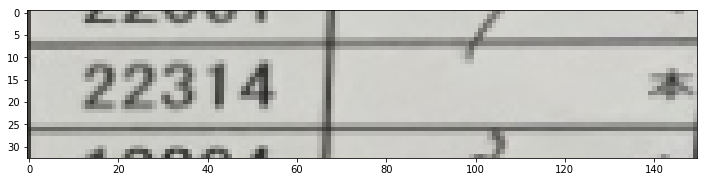

crop


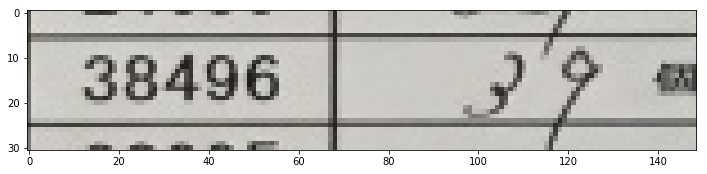

wraped


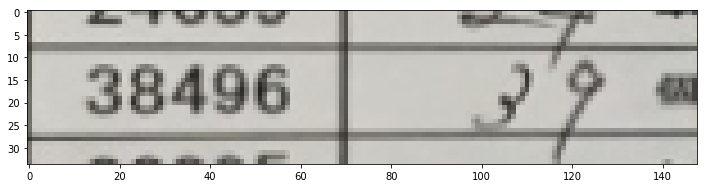

crop


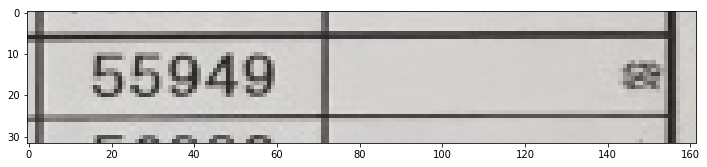

wraped


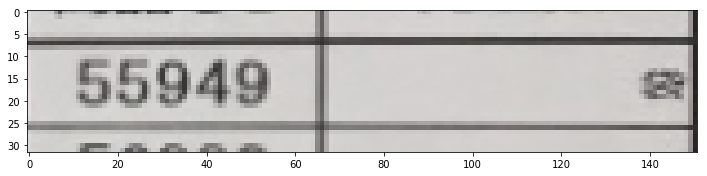

crop


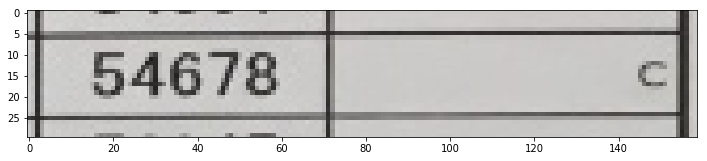

wraped


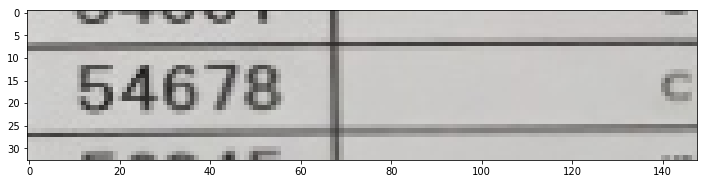

crop


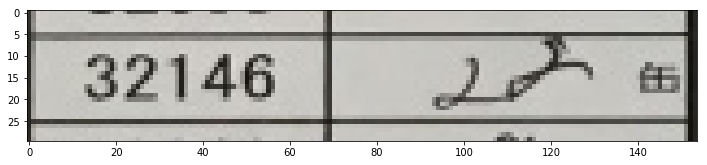

wraped


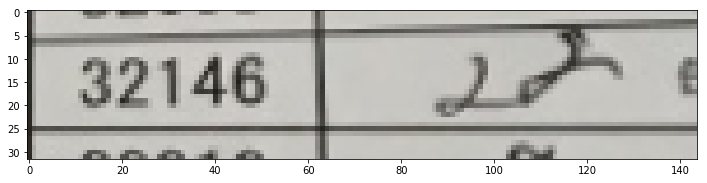

crop


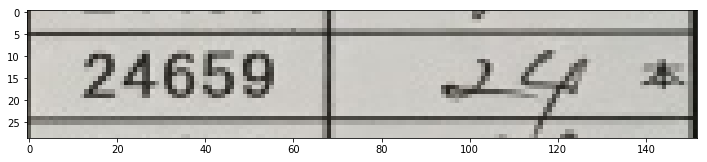

wraped


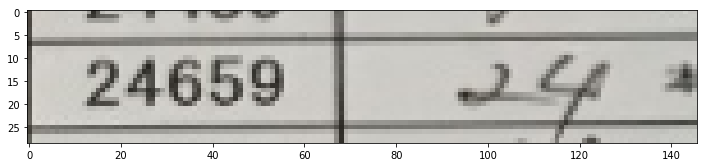

crop


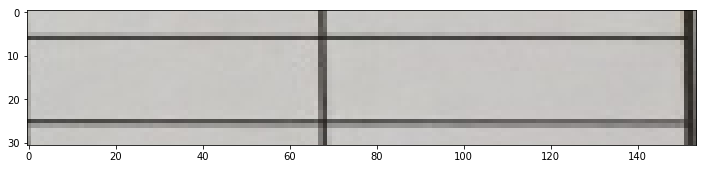

wraped


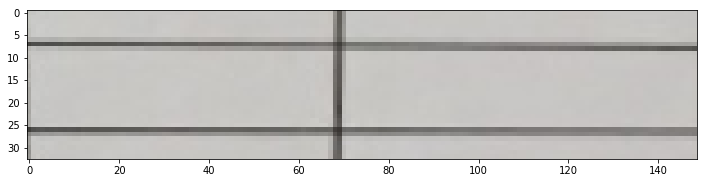

crop


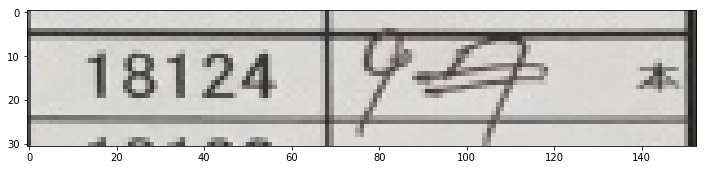

wraped


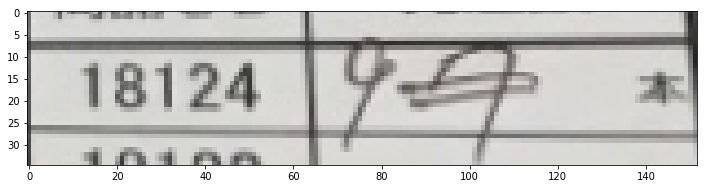

crop


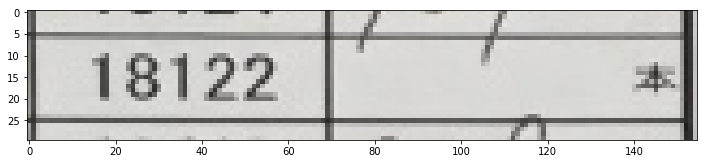

wraped


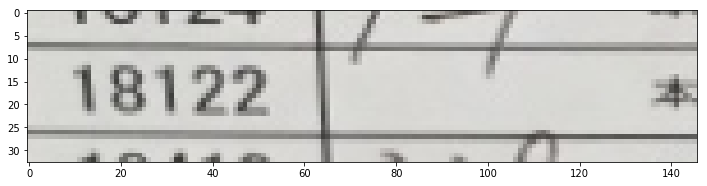

crop


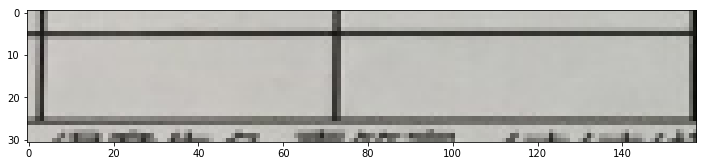

wraped


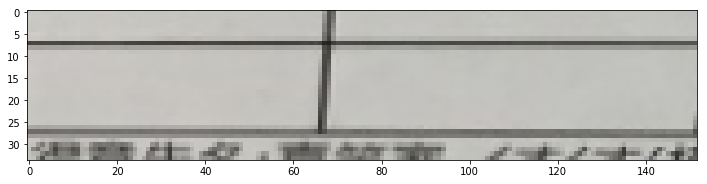

crop


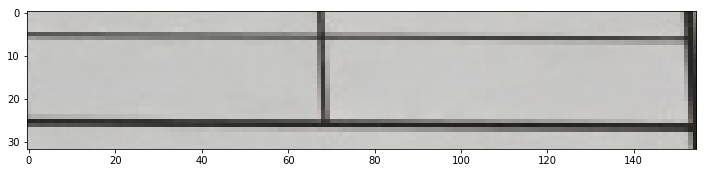

wraped


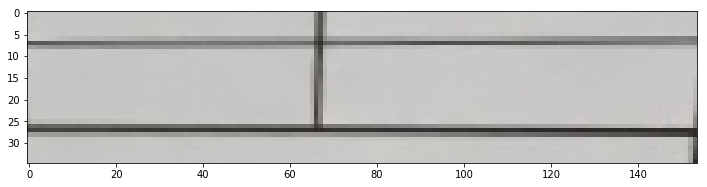

crop


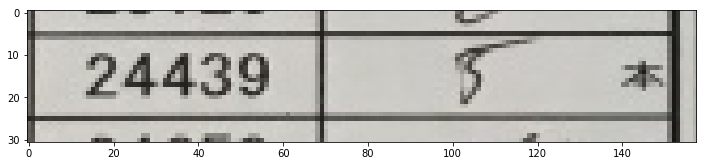

wraped


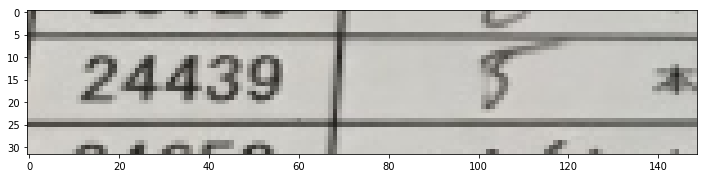

crop


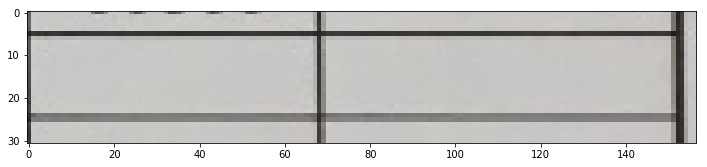

wraped


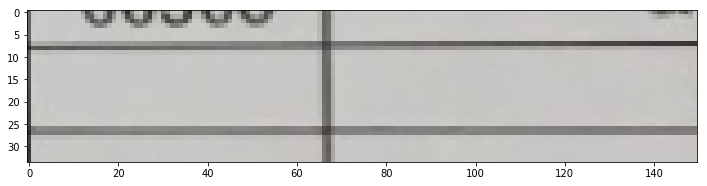

crop


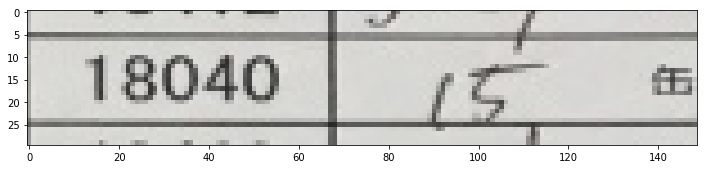

wraped


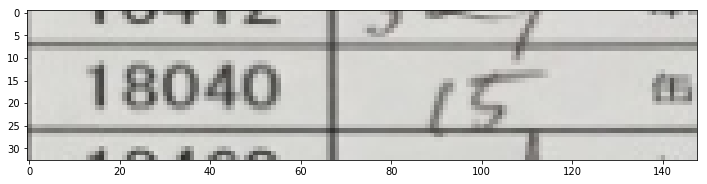

crop


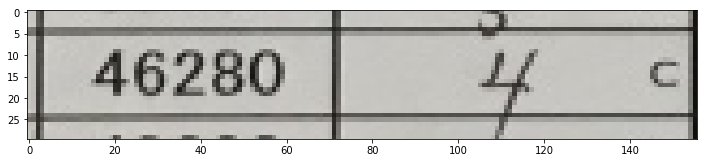

wraped


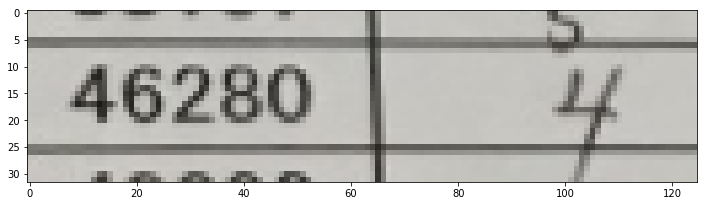

crop


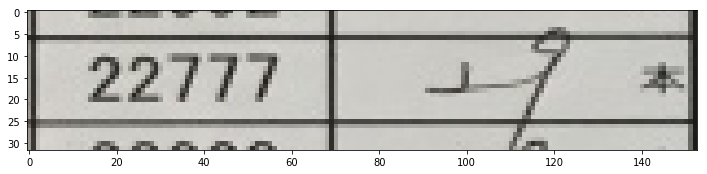

wraped


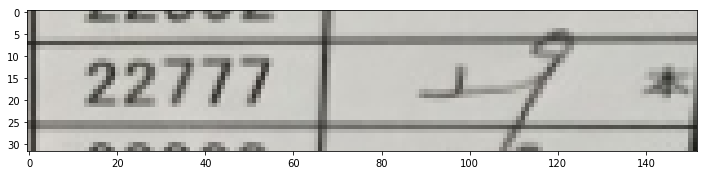

crop


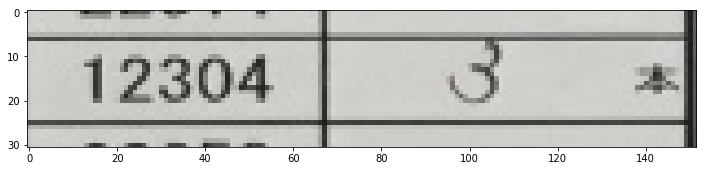

wraped


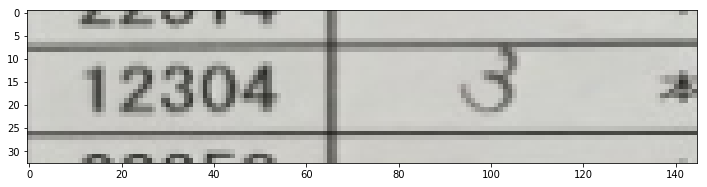

crop


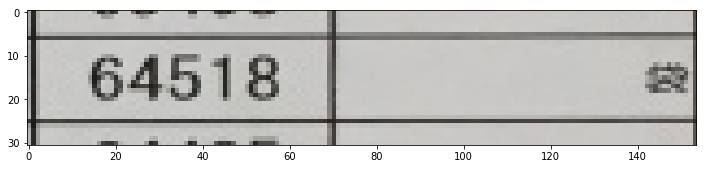

wraped


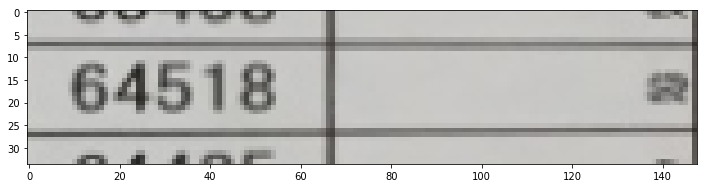

crop


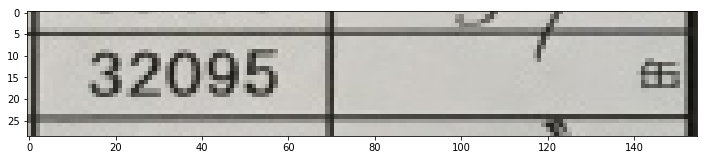

wraped


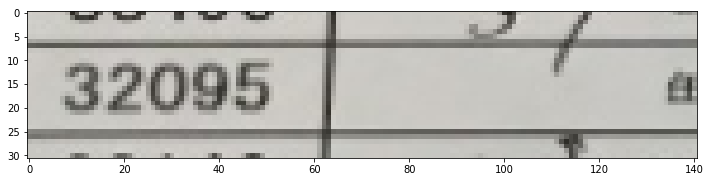

crop


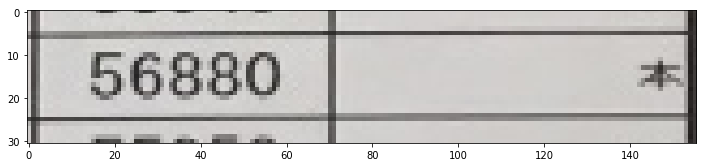

wraped


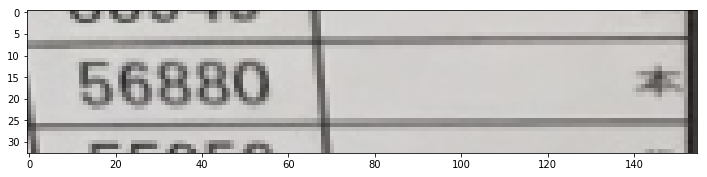

crop


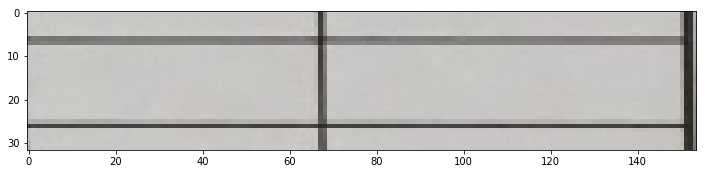

wraped


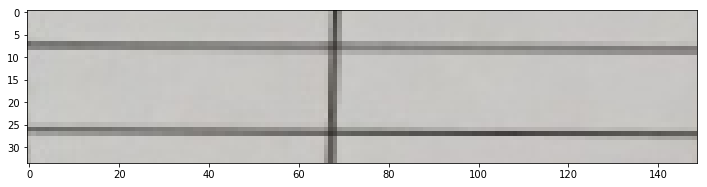

crop


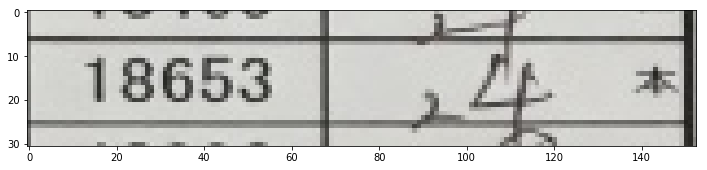

wraped


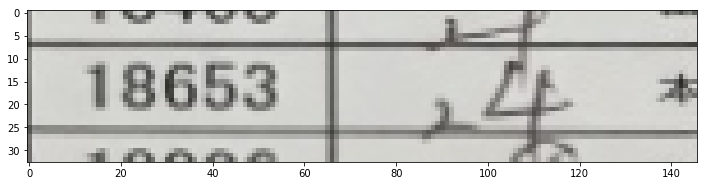

crop


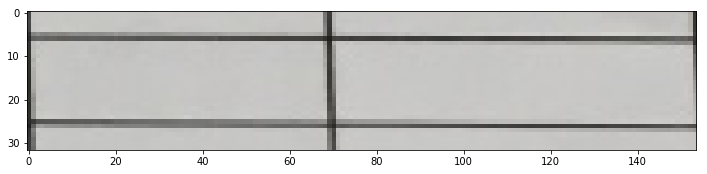

wraped


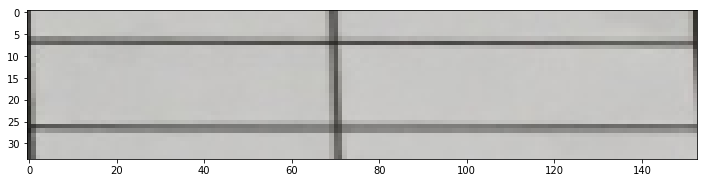

crop


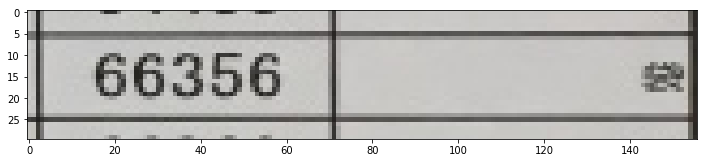

wraped


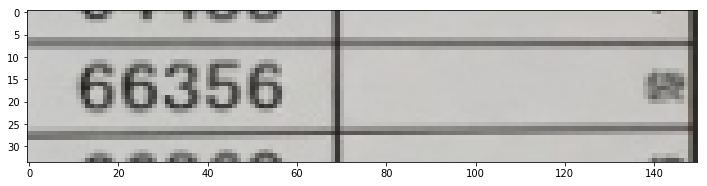

crop


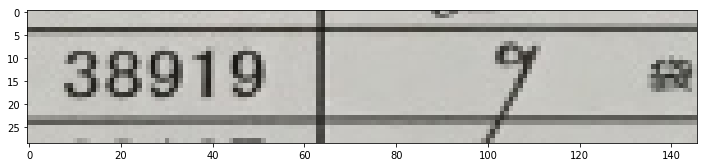

wraped


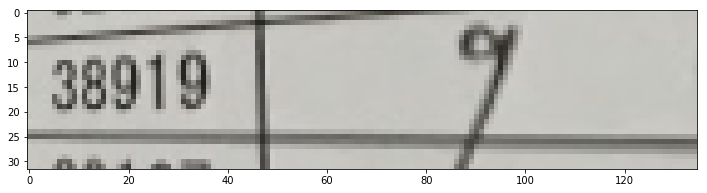

crop


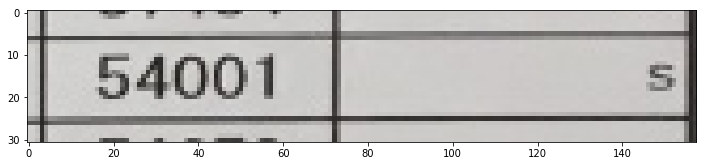

wraped


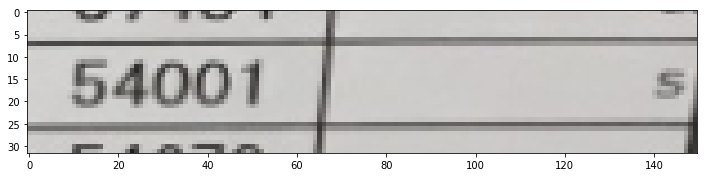

crop


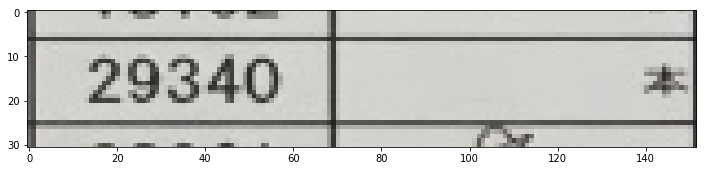

wraped


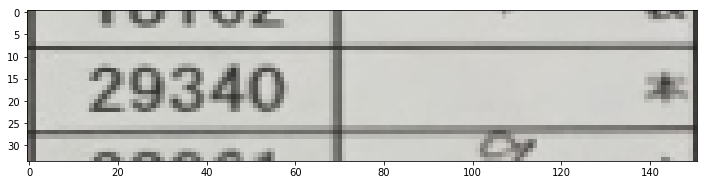

crop


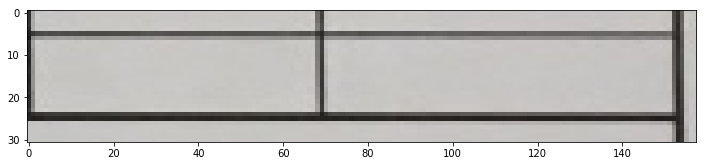

wraped


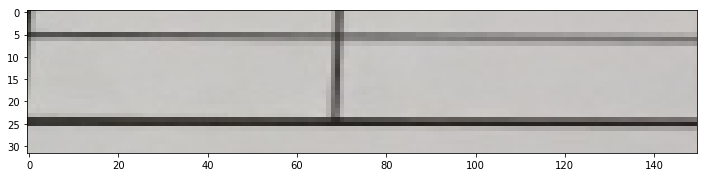

crop


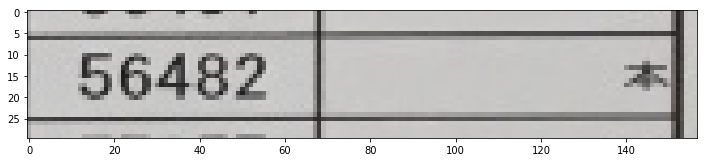

wraped


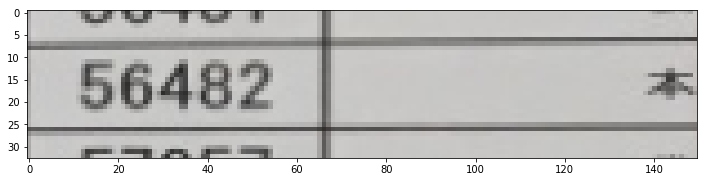

crop


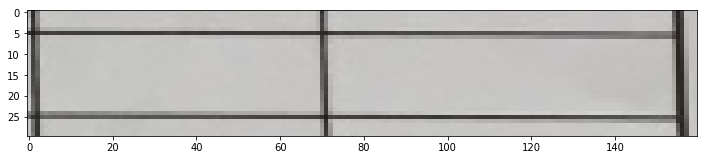

wraped


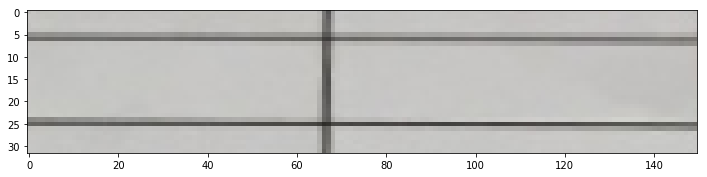

crop


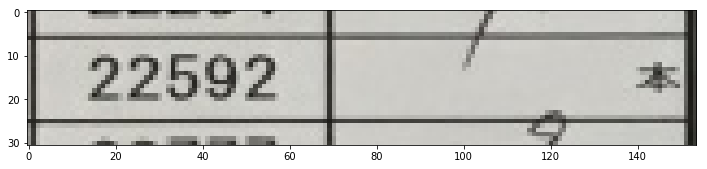

wraped


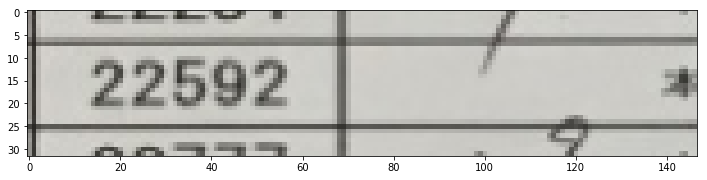

crop


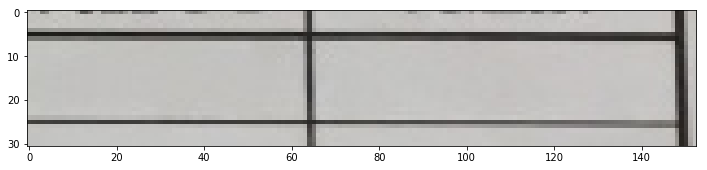

wraped


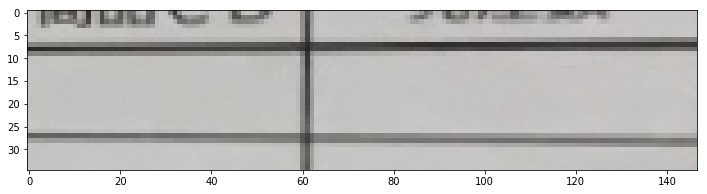

crop


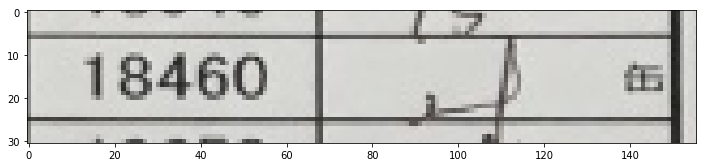

wraped


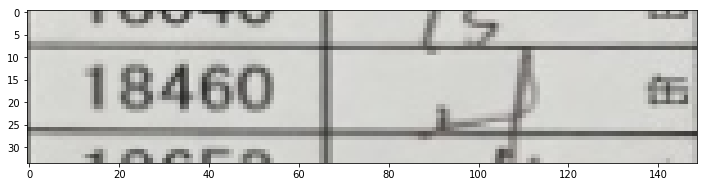

crop


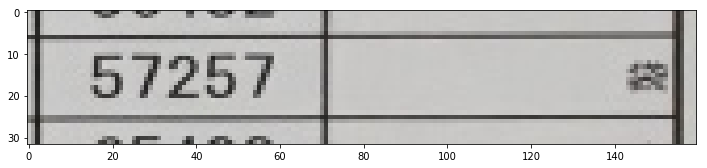

wraped


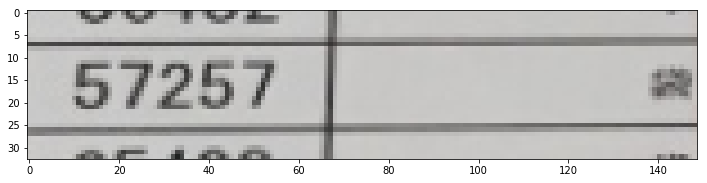

crop


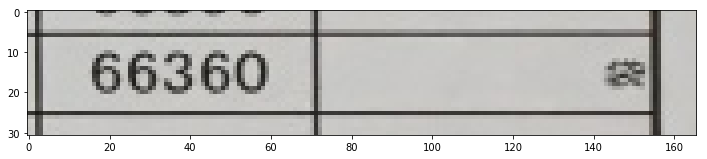

wraped


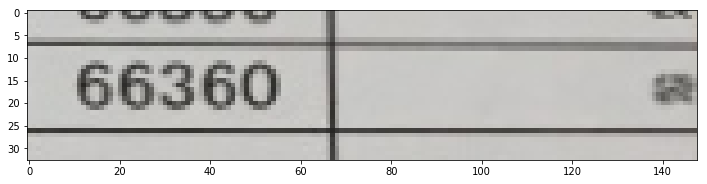

crop


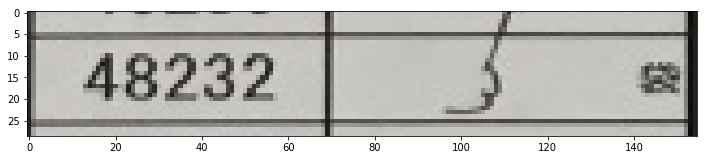

wraped


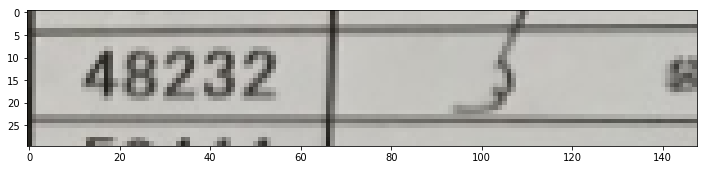

crop


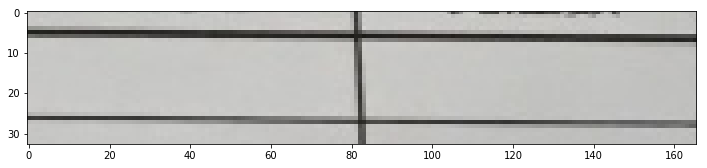

wraped


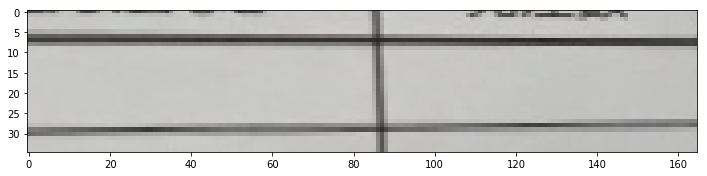

In [13]:
predict_and_extract(1, dataset_val)
# print(dataset_val.image_ids)
# for image_id in dataset_val.image_ids:
#     print(image_id)
#     predict_and_extract(image_id, dataset_val, save_dir="data/handwriting")

In [62]:
import skimage
class_names = ['BG', 'box']
def predict_and_extract1(image_path, i=0, save_dir=""):
    image = skimage.io.imread(image_path)
    results = model.detect([image], verbose=1)

    r = results[0]
#     print(r['masks'].shape)
#     print(r['rois'].shape)
#     print(r['class_ids'].shape)
#     print(r['masks'][:,:,i:i+1].shape)
#     visualize.display_instances(image, r['rois'][i:i+1,:], r['masks'][:,:,i:i+1], r['class_ids'][i:i+1], 
#                             class_names, r['scores'][i:i+1])
    return image, r


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    5.00000  max:  251.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -104.80000  max:  143.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000
(1024, 1024, 46)
(46, 4)
(46,)
(1024, 1024, 1)
crop


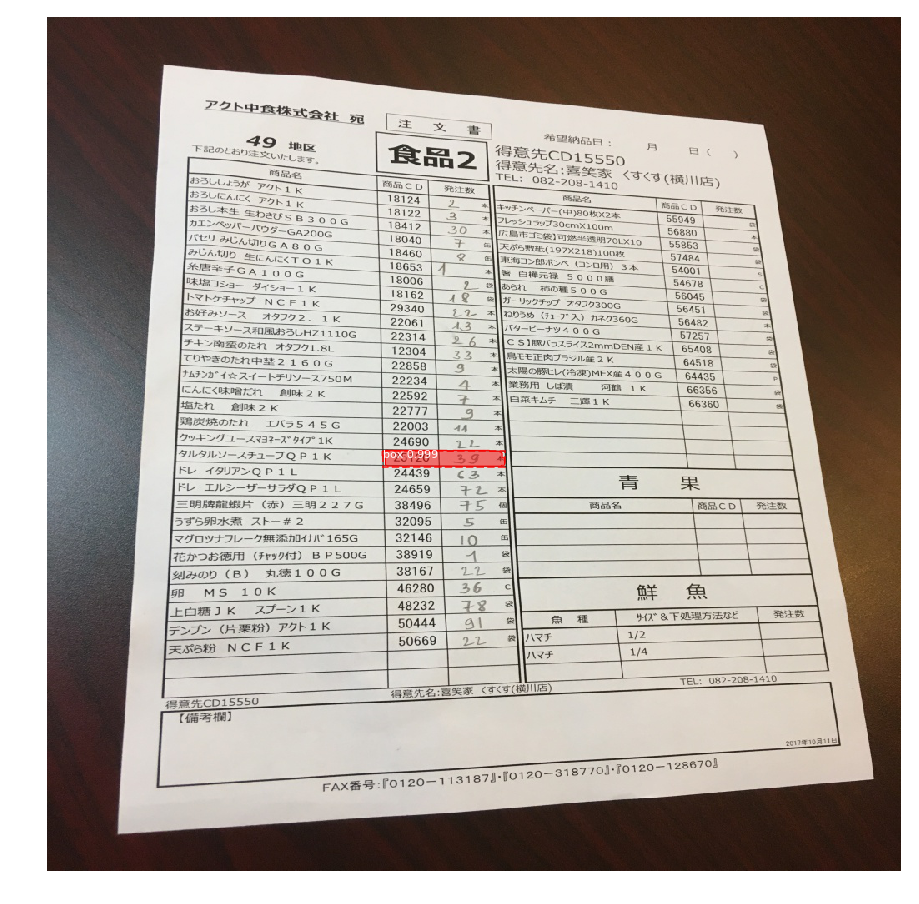

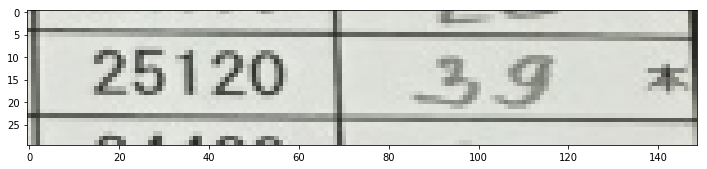

wraped


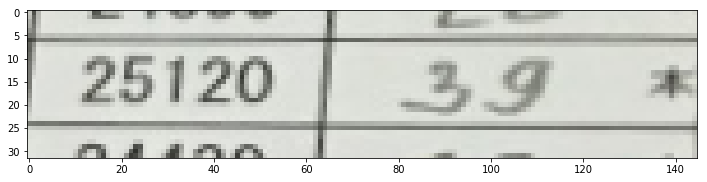

In [15]:
i = 10
image_id = 3
image, r = predict_and_extract1("data/image/imageresized_66.jpg", i=i)
crops, wraps = extract_pred(image_id, image, r['masks'][:,:,i:i+1], r['rois'][i:i+1,:],  r['class_ids'][i:i+1], class_pred=1, save_dir="")

crop


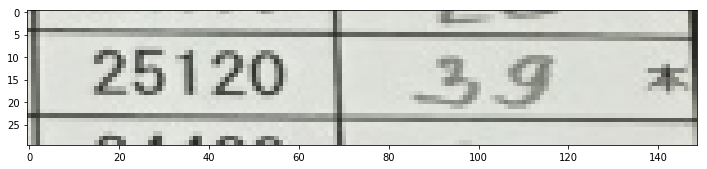

wraped


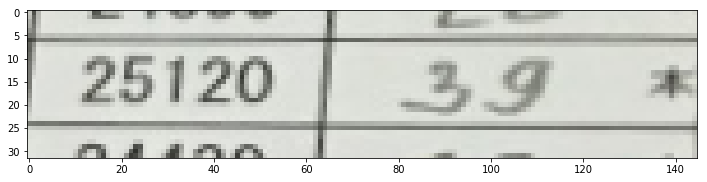

crop


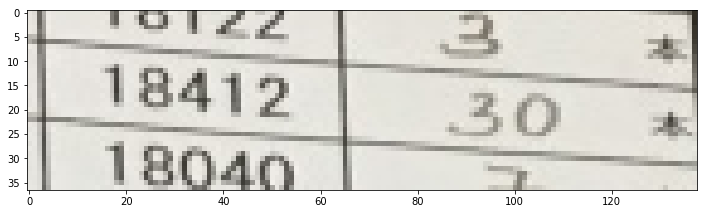

wraped


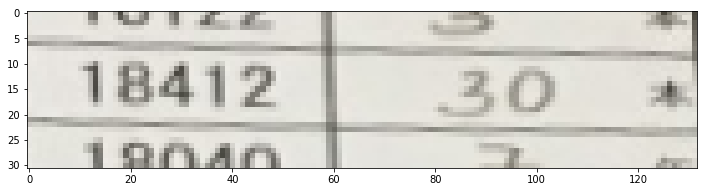

crop


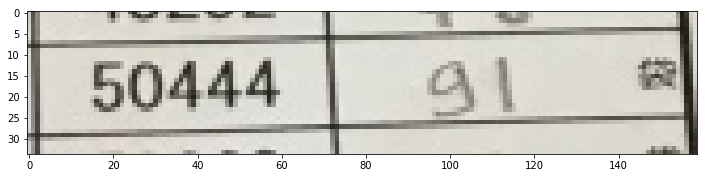

wraped


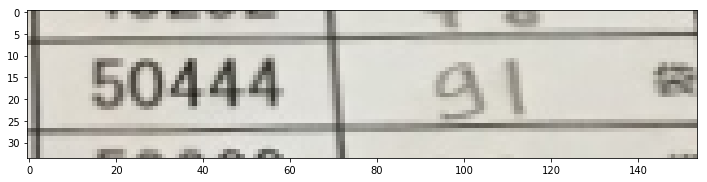

crop


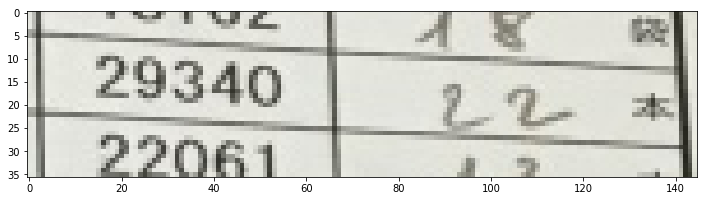

wraped


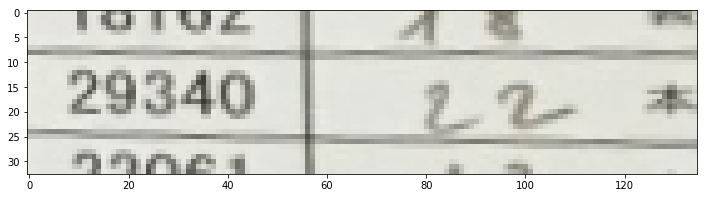

crop


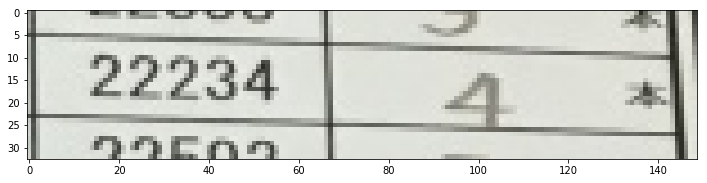

wraped


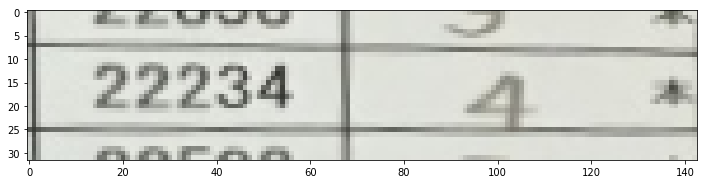

crop


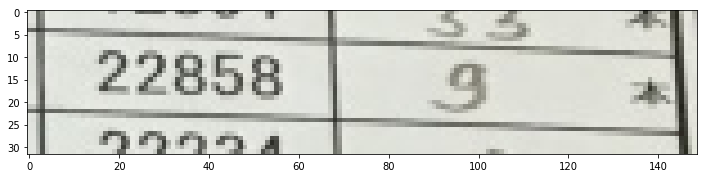

wraped


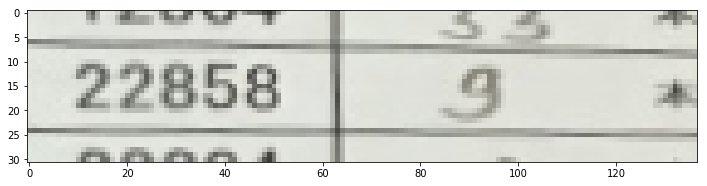

crop


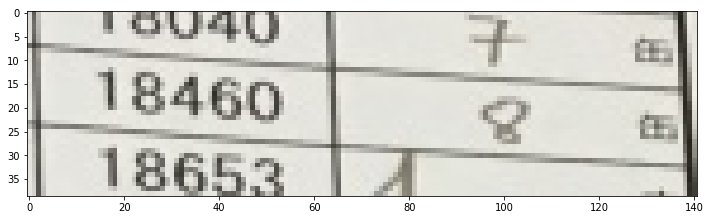

wraped


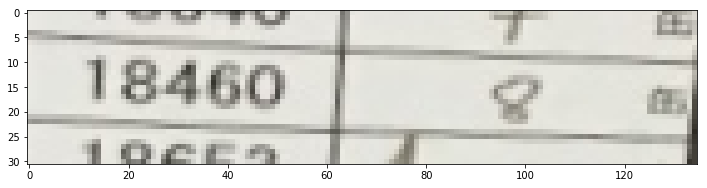

crop


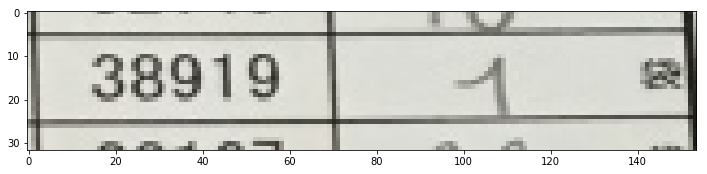

wraped


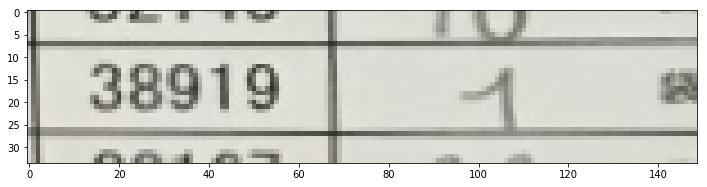

crop


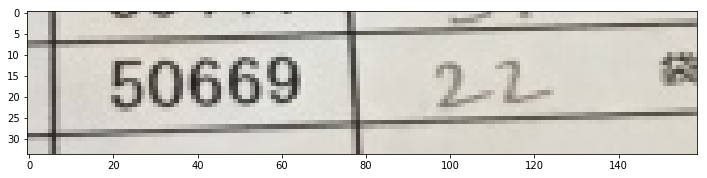

wraped


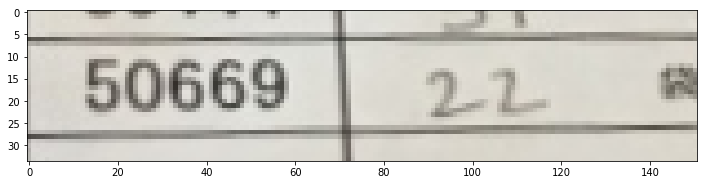

crop


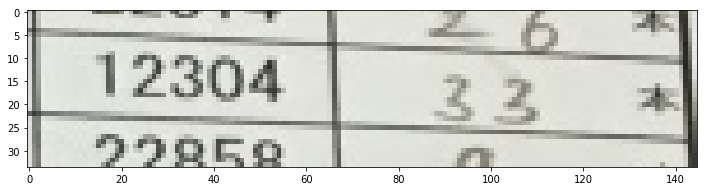

wraped


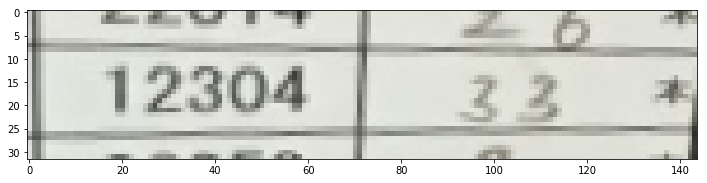

crops (10,) wraps (10,)


In [16]:
i = 10
j = i+10
crops, wraps = extract_pred(image_id, image, r['masks'][:,:,i:j], r['rois'][i:j,:],  r['class_ids'][i:j], class_pred=1, save_dir="")
print("crops", np.array(crops).shape, "wraps", np.array(wraps).shape)

(30, 149, 3)
(37, 138, 3)
(34, 159, 3)


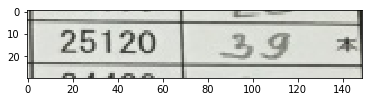

In [16]:
print(np.array(crops[0]).shape)
print(np.array(crops[1]).shape)
print(np.array(crops[2]).shape)
plt.imshow(crops[0])
plt.show()

(32, 145, 3)
(31, 132, 3)
(34, 154, 3)


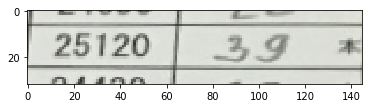

In [17]:
print(np.array(wraps[0]).shape)
print(np.array(wraps[1]).shape)
print(np.array(wraps[2]).shape)

plt.imshow(wraps[0])
plt.show()

In [17]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 3))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

(10,)
(30, 149, 3)


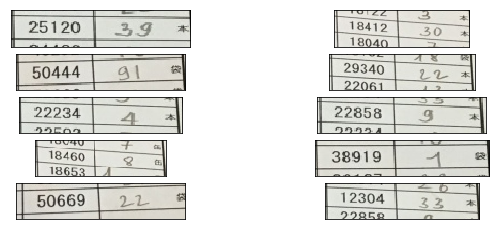

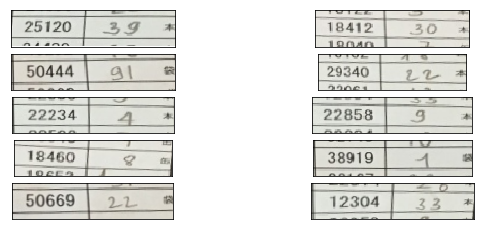

In [18]:
print(np.array(crops).shape)
print(np.array(crops[0]).shape)
show_images(crops)
show_images(wraps)

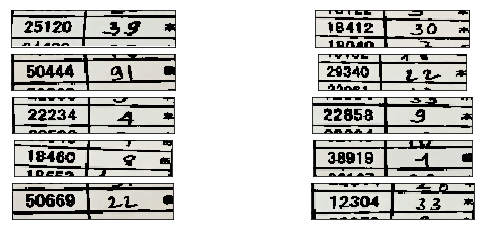

In [19]:
# image is expected be in RGB color space
def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([200, 200,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

show_images(list(map(select_rgb_white_yellow, wraps)))

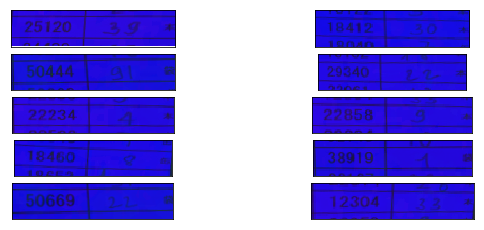

In [20]:
def convert_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

show_images(list(map(convert_hsv, wraps)))

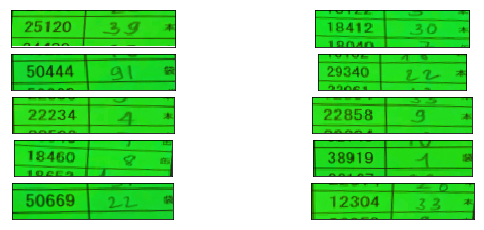

In [21]:
def convert_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

show_images(list(map(convert_hls, wraps)))

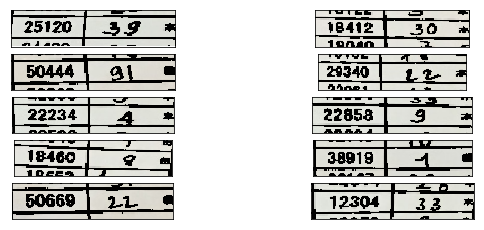

In [22]:
def select_white_yellow(image):
    converted = convert_hls(image)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mask)

white_yellow_images = list(map(select_white_yellow, wraps))

show_images(white_yellow_images)

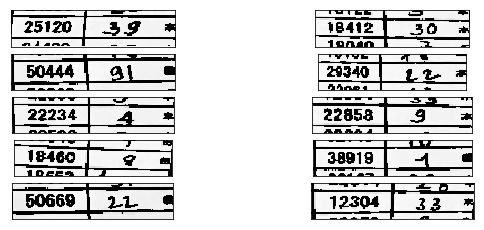

In [23]:
def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_gray_scale, white_yellow_images))

show_images(gray_images)

In [24]:
def apply_smoothing(image, kernel_size=3):
    """
    kernel_size must be postivie and odd
    """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

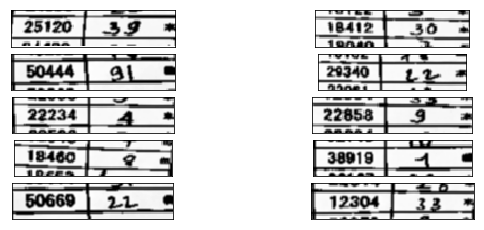

In [25]:
blurred_images = list(map(lambda image: apply_smoothing(image), gray_images))

show_images(blurred_images)

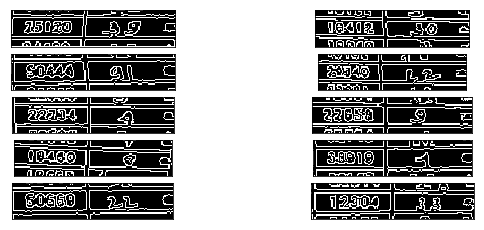

In [26]:
def detect_edges(image, low_threshold=100, high_threshold=150):
    return cv2.Canny(image, low_threshold, high_threshold)

edge_images = list(map(lambda image: detect_edges(image), blurred_images))

show_images(edge_images)

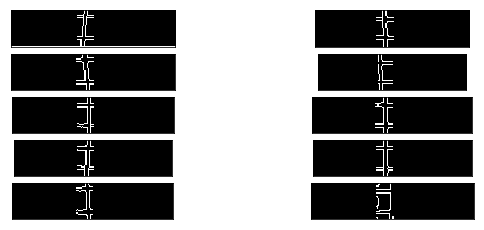

In [27]:
def filter_region(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)

    
def select_region(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
#     bottom_left  = [cols*0.1, rows*0.95]
    bottom_left  = [cols*0.4, rows]
    top_left     = [cols*0.4, 0]
    top_right    = [cols*0.5, 0] 
    bottom_right = [cols*0.5, rows]
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)


# images showing the region of interest only
roi_images = list(map(select_region, edge_images))

show_images(roi_images)

In [28]:
def hough_lines(image):
    """
    `image` should be the output of a Canny transform.
    
    Returns hough lines (not the image with lines)
    """
    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)


list_of_lines = list(map(hough_lines, roi_images))

In [29]:
np.array(list_of_lines).shape

(10,)

image (32, 145, 3)
x1,y1,x2,y2 (64, 31) (67, 1)
image (32, 145, 3)
x1,y1,x2,y2 (61, 31) (64, 3)
image (31, 132, 3)
x1,y1,x2,y2 (57, 0) (58, 30)
image (31, 132, 3)
x1,y1,x2,y2 (60, 0) (61, 30)
image (34, 154, 3)
x1,y1,x2,y2 (67, 1) (70, 30)
image (34, 154, 3)
x1,y1,x2,y2 (71, 0) (73, 33)
image (33, 135, 3)
x1,y1,x2,y2 (54, 0) (54, 27)
image (33, 135, 3)
x1,y1,x2,y2 (57, 0) (58, 29)
image (32, 143, 3)
x1,y1,x2,y2 (66, 31) (66, 0)
image (32, 143, 3)
x1,y1,x2,y2 (69, 31) (69, 0)
image (31, 137, 3)
x1,y1,x2,y2 (61, 30) (61, 0)
image (31, 137, 3)
x1,y1,x2,y2 (64, 30) (64, 0)
image (31, 135, 3)
x1,y1,x2,y2 (63, 30) (65, 0)
image (31, 135, 3)
x1,y1,x2,y2 (60, 30) (62, 0)
image (34, 149, 3)
x1,y1,x2,y2 (66, 33) (66, 0)
image (34, 149, 3)
x1,y1,x2,y2 (69, 33) (69, 0)
image (34, 151, 3)
x1,y1,x2,y2 (71, 0) (73, 33)
image (34, 151, 3)
x1,y1,x2,y2 (68, 0) (69, 30)
image (32, 144, 3)
x1,y1,x2,y2 (70, 23) (70, 0)


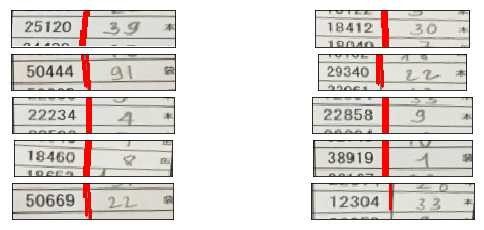

In [30]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=2, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    for line in lines:
        for x1,y1,x2,y2 in line:
            print("image", image.shape)
            print("x1,y1,x2,y2", (x1,y1),(x2,y2))
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image


line_images = []
for image, lines in zip(wraps, list_of_lines):
    line_images.append(draw_lines(image, lines))
    
show_images(line_images)

lines: 2
[[[64 31 67  1]]

 [[61 31 64  3]]]
lines: 2
[[[57  0 58 30]]

 [[60  0 61 30]]]
lines: 2
[[[67  1 70 30]]

 [[71  0 73 33]]]
lines: 2
[[[54  0 54 27]]

 [[57  0 58 29]]]
lines: 2
[[[66 31 66  0]]

 [[69 31 69  0]]]
lines: 2
[[[61 30 61  0]]

 [[64 30 64  0]]]
lines: 2
[[[63 30 65  0]]

 [[60 30 62  0]]]
lines: 2
[[[66 33 66  0]]

 [[69 33 69  0]]]
lines: 2
[[[71  0 73 33]]

 [[68  0 69 30]]]
lines: 1
[[[70 23 70  0]]]


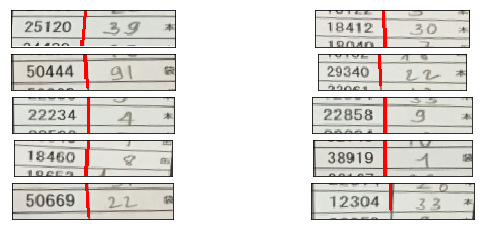

In [31]:
def draw_lines_avg(image, lines, color=[255, 0, 0], thickness=2, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    x1_avg = y1_avg = x2_avg = y2_avg = 0.0
    for line in lines:
        for x1,y1,x2,y2 in line:
#             print("image", image.shape)
#             print("x1,y1,x2,y2", (x1,y1),(x2,y2))
#             cv2.line(image, (x1, y1), (x2, y2), color, thickness)
            x1_avg += x1
            y1_avg += y1
            x2_avg += x2
            y2_avg += y2
    
    x1_avg /= len(lines)
    y1_avg /= len(lines)
    x2_avg /= len(lines)
    y2_avg /= len(lines)
    cv2.line(image, (int(x1_avg), int(y1_avg)), (int(x2_avg), int(y2_avg)), color, thickness)
        
    return image

line_images_avg = []
for image, lines in zip(wraps, list_of_lines):
    print("lines:", len(lines))
    print(lines)
    line_images_avg.append(draw_lines_avg(image, lines))
    
show_images(line_images_avg)

In [32]:
def average_slope_intercept(lines):
    left_lines    = [] # (slope, intercept)
    left_weights  = [] # (length,)
    right_lines   = [] # (slope, intercept)
    right_weights = [] # (length,)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0: # y is reversed in image
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    
    # add more weight to longer lines    
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
    
    return left_lane, right_lane # (slope, intercept), (slope, intercept)

In [40]:
def make_line_points(y1, y2, line):
    """
    Convert a line represented in slope and intercept into pixel points
    """
    if line is None:
        return None
    
    slope, intercept = line
    
    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

10


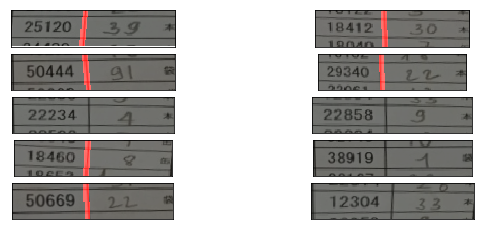

In [68]:
def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
#     print("left_lane, right_lane",left_lane, right_lane)
    
    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.05         # slightly lower than the middle

    left_line  = make_line_points(y1, y2, left_lane)
    right_line = make_line_points(y1, y2, right_lane)
    
    return left_line, right_line

    
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=3):
    # make a separate image to draw lines and combine with the orignal later
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    return cv2.addWeighted(image, 0.5, line_image, 1.0, 0.0)
#     return line_image
             

print(len(list_of_lines))
lane_images = []
for image, lines in zip(wraps, list_of_lines):
#     print(lines)
    lane_images.append(draw_lane_lines(image, lane_lines(image, lines)))

    
show_images(lane_images)

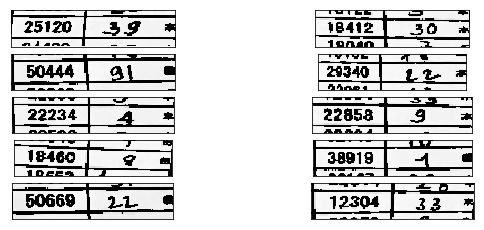

In [33]:
show_images(gray_images)

(31, 132)


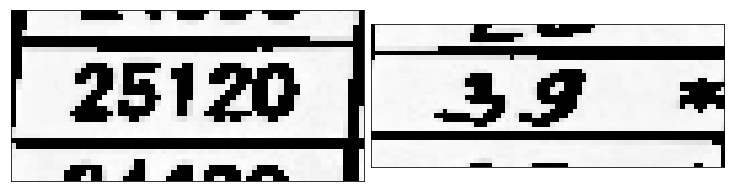

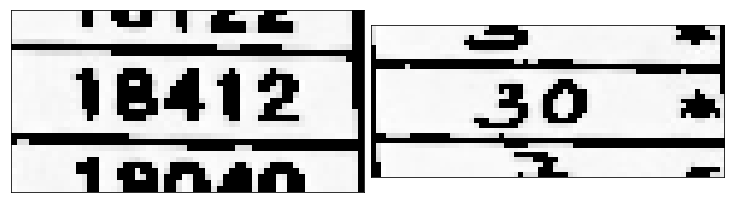

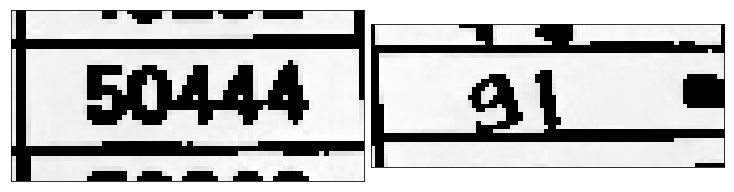

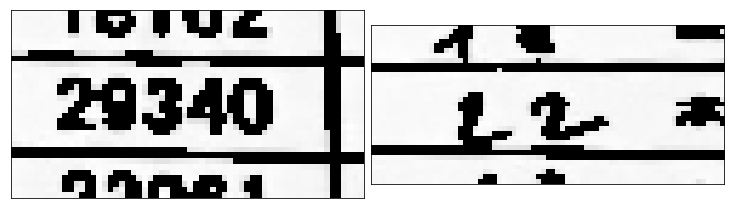

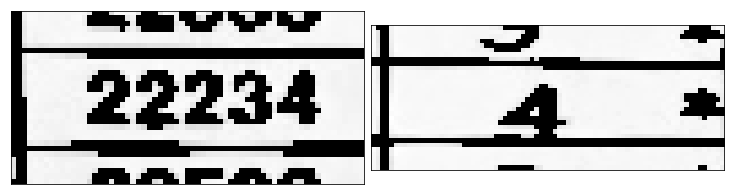

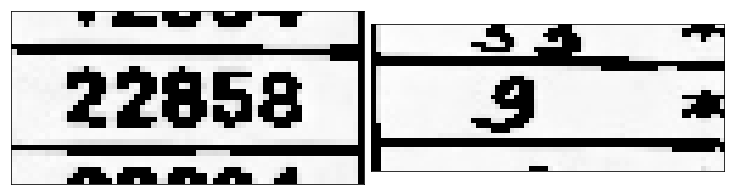

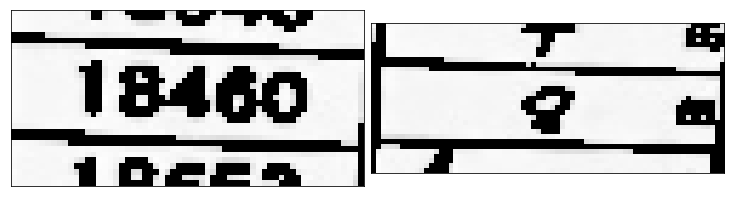

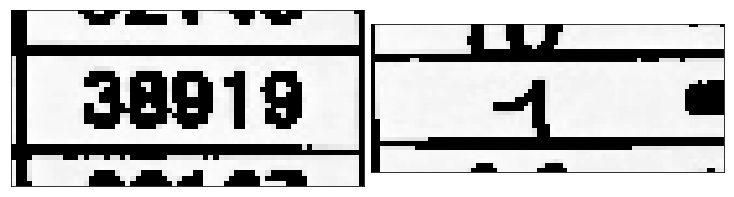

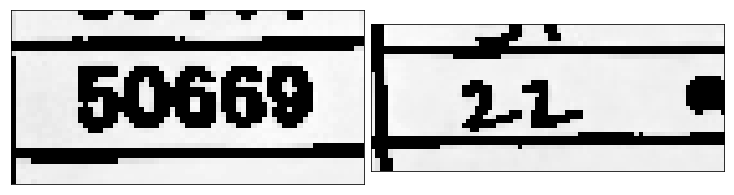

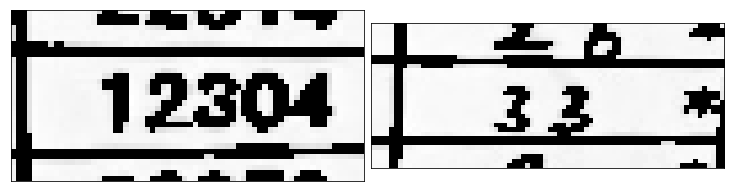

In [34]:
print(gray_images[1].shape)

def split_image(image, percent=0.45):
    rows, cols = image.shape[:2]
    left = image.copy()
    left = left[:,0:int(cols*percent)]
    # plt.imshow(left,cmap=None)
    # plt.show()
    right = image.copy()
    right = right[:,int(cols*percent):cols]
    # plt.imshow(right,cmap=None)
    # plt.show()
    return left, right

for image in gray_images:
    left, right = split_image(image, percent=0.46)
    show_images([left, right])


(32, 145, 3)


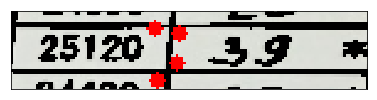

In [35]:
img = white_yellow_images[0].copy()
print(img.shape)
gray = roi_images[0].copy()
gray = np.float32(gray)
# dst = cv2.cornerHarris(gray,3,3,0.04)

# #result is dilated for marking the corners, not important
# dst = cv2.dilate(dst,None)

# # Threshold for an optimal value, it may vary depending on the image.
# img[dst>0.01*dst.max()]=[0,0,255]

# show_images([img])

corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv2.circle(img,(x,y),3,255,-1)
    
show_images([img])

In [36]:
import handwriting
    
config = handwriting.HandwritingConfig()
config.display()
h, w = config.IMAGE_SHAPE[:2]
print(2**6)

print(h)
print(w)
class InferenceConfig(handwriting.HandwritingConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
modelh = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
modelh_path = modelh.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert modelh_path != "", "Provide path to trained weights"
print("Loading weights from ", modelh_path)
modelh.load_weights(modelh_path, by_name=True)


Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     10
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        10
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 10
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               10
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           handwriting
NUM_CLASSES                    11
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         200

In [38]:
def get_predict_order(boxes):
    N = boxes.shape[0]
    middles = []
    for i in range(N):
        y1, x1, y2, x2 = boxes[i]
        middle_x = (x1+x2)/2
        middles.append((i, middle_x))
        
    dtype = [('index', int), ('middle', float)]
    a = np.array(middles, dtype=dtype)
    np.sort(a, order='middle')
    return a
def predict_value(orders, class_ids):
    predict = []
    for i in range(orders.shape[0]):
        idx, _ = orders[i]
        class_id = class_ids[idx]
        if class_id == 10:
            class_id = 0
        predict.append(class_id)
    return predict

In [65]:
import pytesseract
import visualize
class_names = ['BG', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0']

def predict_all(images):
    presults = []
    for image in images:
        left, right = split_image(image, percent=0.46)
    #     text = pytesseract.image_to_string(left, config='-tessedit_char_whitelist=0123456789 -psm 6')
    #     print("left result", text)
        resized_left = cv2.resize(left, (128, 64))
        resized_right = cv2.resize(right, (128, 64))
        show_images([resized_left, resized_right])
    #     print(right.shape)
    #     print(resized.shape)
    #     plt.imshow(resized)
    #     plt.show()
        print("--predict left tesseract--")
        text = pytesseract.image_to_string(resized_left, lang='eng', config='--tessedit_char_whitelist=0123456789 --psm 6')
        print(text)
        print("--predict left--")
        results = modelh.detect([resized_left], verbose=0)

        r = results[0]
        orders = get_predict_order(r['rois'])
        left_predicts = predict_value(orders, r['class_ids'])
        print(left_predicts)
    #     print(r['masks'].shape)
    #     print(r['masks'][:,:,0].shape)
    #     print(r['class_ids'])
    #     print(r['scores'])
    #     visualize.display_instances(resized_left, r['rois'], r['masks'], r['class_ids'], 
    #                             class_names, r['scores'], figsize=(5, 5))
        print("--predict right--")
        results = modelh.detect([resized_right], verbose=0)
        r = results[0]
        orders = get_predict_order(r['rois'])
        right_predicts = predict_value(orders, r['class_ids'])
        print(right_predicts)
        presults.append((text,left_predicts,right_predicts))
    
    return presults
    #     print(r['masks'].shape)
    #     print(r['masks'][:,:,0].shape)
    #     print(r['class_ids'])
    #     print(r['scores'])
    #     visualize.display_instances(resized_right, r['rois'], r['masks'], r['class_ids'], 
    #                             class_names, r['scores'], figsize=(5, 5))
    

In [ ]:

image_id = 3
image, r = predict_and_extract1("data/image/imageresized_66.jpg", i=0)
i = 0
j = i+10
crops, wraps = extract_pred(image_id, image, r['masks'][:,:,i:j], r['rois'][i:j,:],  r['class_ids'][i:j], class_pred=1, save_dir="")
print("crops", np.array(crops).shape, "wraps", np.array(wraps).shape)
white_yellow_images = list(map(select_white_yellow, wraps))

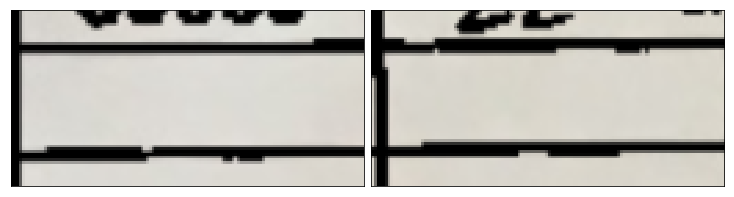

--predict left tesseract--

--predict left--
[1, 1]
--predict right--


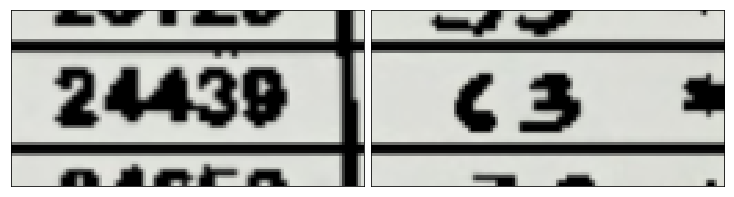

--predict left tesseract--

--predict left--
[1, 1]
--predict right--


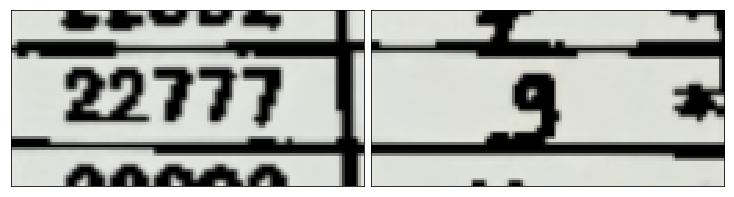

--predict left tesseract--
nun--—

22777

AAMA
--predict left--
[1, 1]
--predict right--


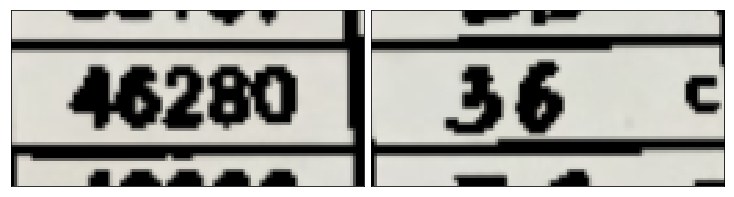

--predict left tesseract--

--predict left--
[1, 1]
--predict right--


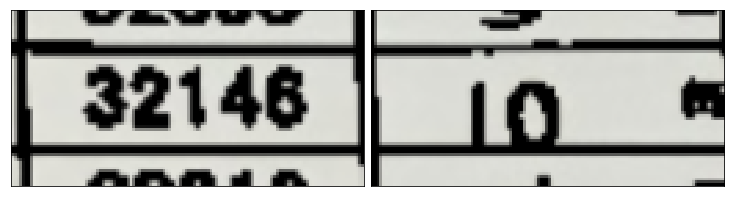

--predict left tesseract--

--predict left--
[1, 1]
--predict right--


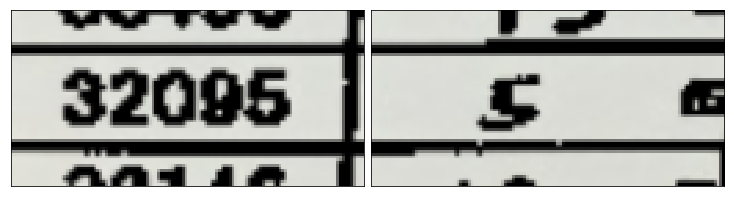

--predict left tesseract--
32095 I
--predict left--
[1, 1]
--predict right--


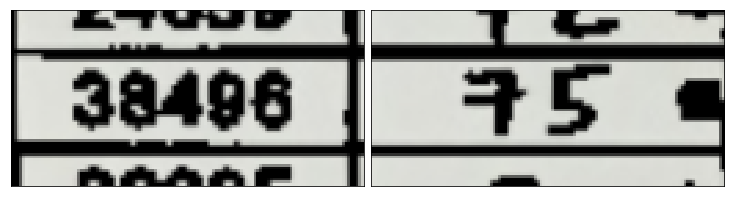

--predict left tesseract--
L-Iw -

gnu...—
--predict left--
[1, 1]
--predict right--


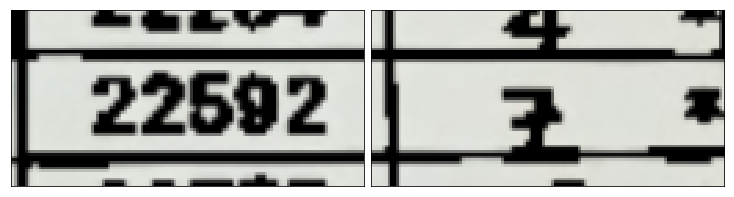

--predict left tesseract--
I 22592
--predict left--
[1, 1]
--predict right--


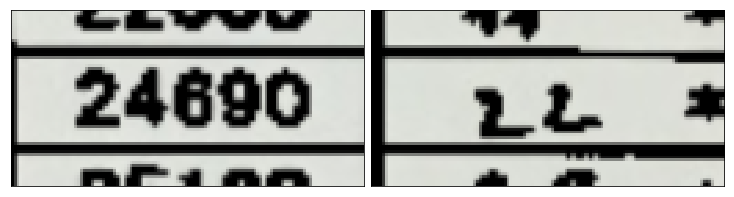

--predict left tesseract--
LLWU
--predict left--
[1, 1]
--predict right--


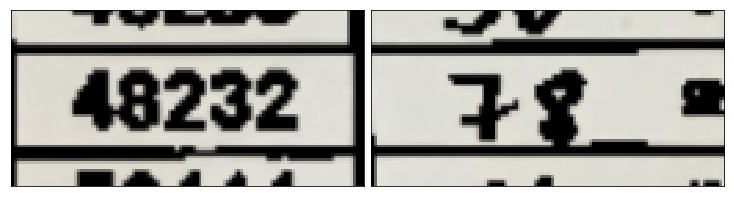

--predict left tesseract--

--predict left--
[1, 1]
--predict right--


[('', [], []),
 ('', [2, 4, 4, 2], [3]),
 ('nun--—\n\n22777\n\nAAMA', [2, 7], [9, 2]),
 ('', [4, 2, 8, 0], [3, 0]),
 ('', [4, 2, 1, 3, 2], [7, 1]),
 ('32095 I', [5, 4, 2], [5]),
 ('L-Iw -\n\ngnu...—', [4, 2], [5, 7]),
 ('I 22592', [2, 5, 2], [7]),
 ('LLWU', [0, 4, 2], [2, 1]),
 ('', [2, 4, 2, 4], [7, 8])]

In [64]:
results = predict_all(white_yellow_images)
results

In [ ]:
# predict_and_extract(1, dataset_val)
print(dataset_train.image_ids)
for image_id in dataset_train.image_ids:
    print(image_id)
    predict_and_extract(image_id, dataset_train, save_dir="data/handwriting_tr")

In [ ]:
i = 72
plt.figure(figsize=(12, 12))

mask = masks[:, :, i]
box = boxes[i]
class_id = classes[i]
crop_img, warped = predict_mask(original_image, mask, box)
plt.imshow(crop_img)
plt.show()
plt.figure(figsize=(12, 12))
plt.imshow(warped)
plt.show()

In [ ]:
print(masks.shape[2])
count = 0

for i in range(masks.shape[2]):
    plt.figure(figsize=(12, 12))

    mask = masks[:, :, i]
    box = boxes[i]
    class_id = classes[i]
    if class_id == 2:
        print('-----------')
        print(i)
        crop_img, warped = predict_mask(original_image, mask, box)
#         print(crop_img)
#         print(warped)
        plt.imshow(crop_img)
        plt.show()
        plt.figure(figsize=(12, 12))
        plt.imshow(warped)
        plt.show()
#         text = pytesseract.image_to_string(warped, config='')
#         print("predict: %s" % text)
#         count = count + 1
#         if count > 10:
#             break